In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from GNS import *
from utils import *

from models import DiT_S_2
from download import find_model
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device.upper()}")

Device: CPU


### ImageNet Data

Data-Path: ./data
Dataset: 50000 Images
Image Shape: (3, 256, 256)


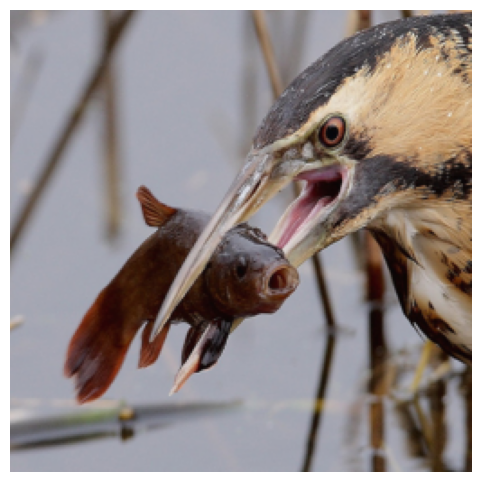

In [2]:
B_SIZE = 64
IMG_DIM = (3, 256, 256)
TRANSFORM = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])
dataset = ImageFolder(DATA_PATH, transform=TRANSFORM)
img, trgt = dataset[10]

print(f"Data-Path: {DATA_PATH}")
print(f"Dataset: {len(dataset)} Images")
print(f"Image Shape: {tuple(img.shape)}")

plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

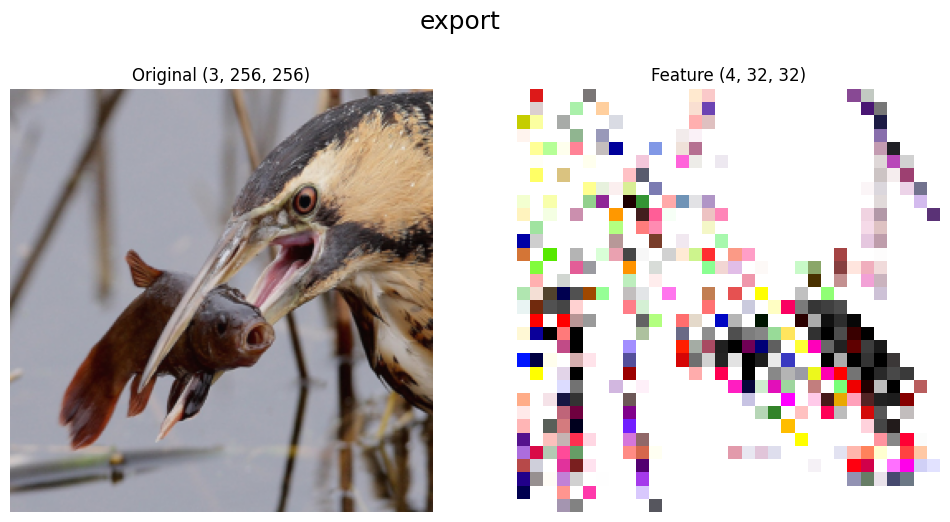

In [3]:
feature_dataset = FeatureDataset()
show_feature(img_no=10)

In [4]:
model = DiT_S_2().to(device)
PATH = "Checkpoints/0750000.pt"
torch.serialization.add_safe_globals([PATH])

state_dict = find_model(PATH)
model.load_state_dict(state_dict)

/Users/egecimsir/Desktop/GenAI Practical/Critical-Multitask-Batch-Sizes-in-Diffusion-Models/download.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.

<All keys matched successfully>

In [5]:
diffusion = create_diffusion("")

In [6]:
GNS = GradientNoiseScale(
        dataset=feature_dataset,
        model=model,
        loss_fn=diffusion.training_losses,
        betas=[...],
        device=device,
        data_portion=0.1
    ).estimate_gns(B_big=30_000, B_small=1_000)


Initializing GNS...

----------------------------------------------
Calculating G_true w.r.t 5000 data points:


  0%|          | 0/1 [00:04<?, ?it/s]


TypeError: DiT.forward() missing 2 required positional arguments: 't' and 'y'